<a href="https://colab.research.google.com/github/Blackman9t/Machine_Learning/blob/master/Understanding_Confusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp



Automatically created module for IPython interactive environment


Let's import our data set from github and read into a Pandas Data frame

In [92]:
data_link = 'https://raw.githubusercontent.com/Blackman9t/Machine_Learning/master/diabetes.csv'

diabetes_df = pd.read_csv(data_link)

diabetes_df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


Let's check the shape and if any missing values exist

In [93]:
diabetes_df.shape

(15000, 10)

In [94]:
diabetes_df.isna().any()

PatientID                 False
Pregnancies               False
PlasmaGlucose             False
DiastolicBloodPressure    False
TricepsThickness          False
SerumInsulin              False
BMI                       False
DiabetesPedigree          False
Age                       False
Diabetic                  False
dtype: bool

Let's look at the distribution of each column, this would help us choose the most ideal feature normalization method.<br>
First let's define a method that plots the distribution of each feature.

In [0]:
def plot_features(data):
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=1.2)
    sns.set_style('ticks') # change background to white background
    plt.suptitle('Visualizing The Features Distribution', y=0.95)

    # For The Bar chart
    plt.subplot(241)
    color_list = ['gold','purple','brown']
    data.Age.plot(kind='hist', color='brown')
    plt.xlabel('Age')
    plt.ylabel('Frequency')

    plt.subplot(242)
    color_list = ['gold','purple','brown']
    data.Pregnancies.plot(kind='hist', color='brown')
    plt.xlabel('Pregnancies')
    plt.ylabel('Frequency')

    plt.subplot(243)
    color_list = ['gold','purple','brown']
    data.PlasmaGlucose.plot(kind='hist', color='brown')
    plt.xlabel('PlasmaGlucose')
    plt.ylabel('Frequency')

    plt.subplot(244)
    color_list = ['gold','purple','brown']
    data.DiastolicBloodPressure.plot(kind='hist', color='brown')
    plt.xlabel('DiastolicBP')
    plt.ylabel('Frequency')

    plt.subplot(245)
    color_list = ['gold','purple','brown']
    data.TricepsThickness.plot(kind='hist', color='brown')
    plt.xlabel('TricepsThickness')
    plt.ylabel('Frequency')

    plt.subplot(246)
    color_list = ['gold','purple','brown']
    data.SerumInsulin.plot(kind='hist', color='brown')
    plt.xlabel('SerumInsulin')
    plt.ylabel('Frequency')


    plt.subplot(247)
    color_list = ['gold','purple','brown']
    data.BMI.plot(kind='hist', color='brown')
    plt.xlabel('BMI')
    plt.ylabel('Frequency')

    plt.subplot(248)
    color_list = ['gold','purple','brown']
    data.DiabetesPedigree.plot(kind='hist', color='brown')
    plt.xlabel('DiabetesPedigree')
    plt.ylabel('Frequency')

    plt.show()

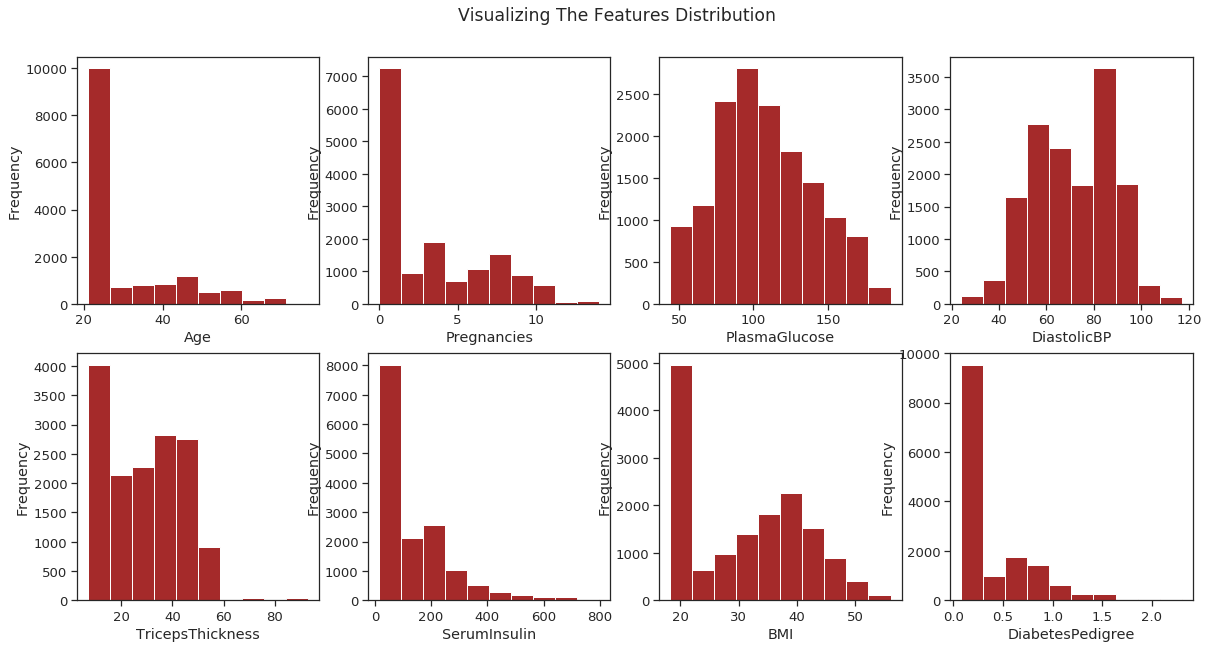

In [96]:
plot_features(diabetes_df)

We can see that features like Age, DiabetesPedigree, SerumInsulin and BMI seem to be skewed to the right.<br>
This is due to a lot of smaller values and a progressive distribution of fewer large values.<br>
Let's make the distribution better by using the log of the values, rather than actual values in these features.<br>
This is a part of the  feature-engineering process in Machine Learning

In [97]:
for i in diabetes_df.columns:
    if i in ['Age', 'DiabetesPedigree', 'BMI', 'SerumInsulin']:
        print(i)
        diabetes_df[i] = diabetes_df[i].apply(np.log)


SerumInsulin
BMI
DiabetesPedigree
Age


Let's view the distribution again

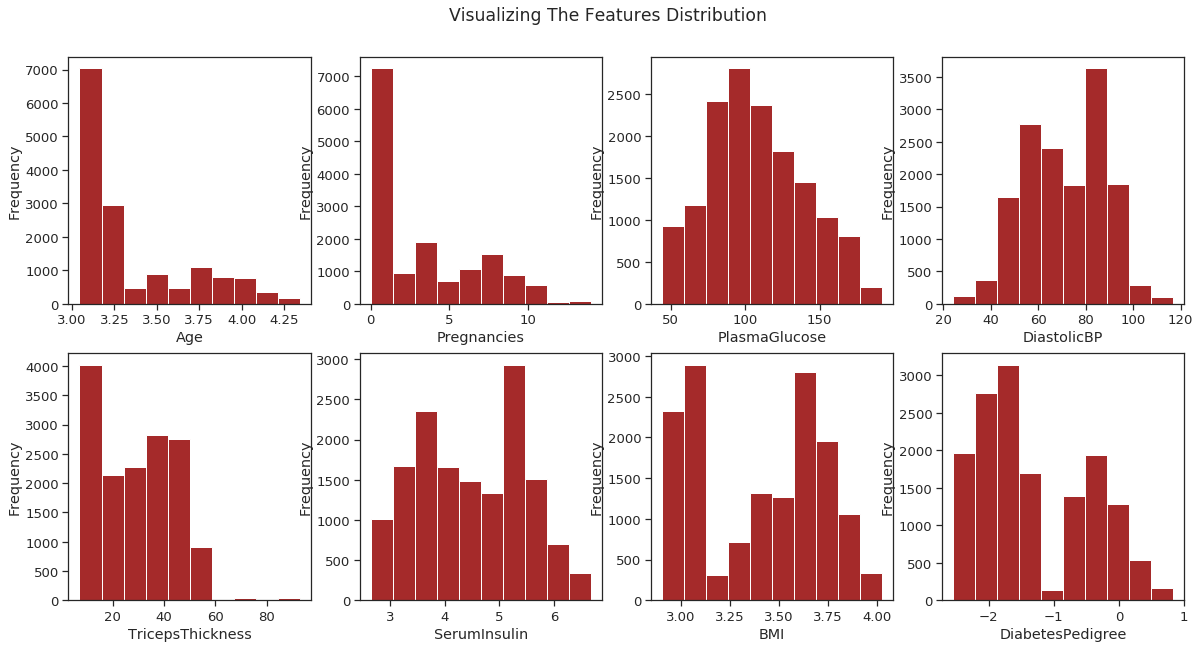

In [98]:
plot_features(diabetes_df)

From the above plots, we can see an improvement to the distribution of our features.<br>
This would help us achieve a better result when we train the model

Okay so now, let's look at the dataset that contains the names of the doctors treating our respective patients.<br>
The raw file is in Github, let's read it to a Dataframe.

In [99]:
doctors_link = 'https://raw.githubusercontent.com/Blackman9t/Machine_Learning/master/doctors.csv'

doctors_df = pd.read_csv(doctors_link, encoding='latin-1')
# Note the above code line throws a UnicodeDecodeError except we encode the string in latin-1 as shown above.

doctors_df.head()

,PatientID,Physician
0,1000038,Jeanne Vestergaard
1,1000069,Sheldon Comeaux
2,1000118,Brain Dulaney
3,1000183,Alaine Poisson
4,1000326,Erik Collado


In [100]:
doctors_df.shape

(14895, 2)

So we can see that the Doctor data is slightly smaller than the patients dataset.<br>
This may be due to the fact that a few doctors saw more than one patient.<br>
Let's left-join the diabetes_df and doctors_df data frames using the PatientID as the join key.<br>
Left-join here is important so that we keep data for patients who may not have doctors names too.

In [101]:
diabetes_doctor_df = pd.merge(diabetes_df, doctors_df, how='left', on='PatientID' )

diabetes_doctor_df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician
0,1354778,0,171,80,34,3.135494,3.772984,0.193254,3.044522,0,Dan Drayton
1,1147438,8,92,93,47,3.583519,3.055913,-1.842853,3.135494,0,Anthony Frizzell
2,1640031,7,115,47,52,3.555348,3.725971,-2.538072,3.135494,0,Gordon Fredrickson
3,1883350,9,103,78,25,5.717028,3.387173,0.249100,3.761200,1,Chad Corbitt
4,1424119,1,85,59,27,3.555348,3.751961,-0.598670,3.091042,0,Zachary Fellows


Now we can see the doctors column appended and can tell which doctor treated a patient.<br>
Let's view the shape and also check the number and columns with null values

In [102]:
diabetes_doctor_df.shape

(15000, 11)

In [103]:
diabetes_doctor_df.isna().sum()

PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
Physician                 0
dtype: int64

### Preparing The Data

As is often the case with machine learning of any kind, some data preparation is required before you can
use the data to train a model.<br>
We shall normalize the features so that features that have large values do not dominate the training.<br>
Looking at the shapes of the distribution of each feature, those with a roughly normal distribution bell-shape will be normalized using the Zscore method.<br>
While those with varying large and low values will be normalized using the Min-Max method.

**1. Z-Score or Standard Score**_  
_For each value here, we subtract the average or mean..._  
_And then divide by the Standard deviation._  
_This gives a range between minus 3 and 3, but can be more or less_  

$Xnew =$ $Xold - mean \over STD(sigma)$

_**2. Min-Max Method**_  
_This method takes each value and subtracts the min and then divides by the range(max - min)..._  
_The resultant values range between zero(0) and one(1)_

$Xnew =$ $Xold - Xmin \over Xmax - Xmin$

Now let's apply these methods to the selected columns using the apply method.

In [0]:
for i in diabetes_doctor_df.columns[:-2]:
    mean = diabetes_doctor_df[i].mean()
    std = diabetes_doctor_df[i].std()
    mini = diabetes_doctor_df[i].min()
    maxi = diabetes_doctor_df[i].max()
    
    # if columns are not Age or Pregnancies, apply the Z_score norm method
    if i not in ['Age', 'Pregnancies']:
        diabetes_doctor_df[i] = diabetes_doctor_df[i].apply(lambda x: (x - mean) / std)
    
    # Else if columns are either Age or Pregnancies, then apply the Min-Max norm method
    else:
        diabetes_doctor_df[i] = diabetes_doctor_df[i].apply(lambda x: (x - mini) / (maxi - mini))
    

In [105]:
diabetes_doctor_df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician
0,-0.512160,0.000000,1.974335,0.523867,0.356286,-1.364665,1.165284,1.755479,0.000000,0,Dan Drayton
1,-1.228971,0.571429,-0.495806,1.299582,1.249406,-0.908607,-1.076800,-0.637939,0.070017,0,Anthony Frizzell
2,0.474010,0.500000,0.223349,-1.445258,1.592914,-0.937283,1.018286,-1.455161,0.070017,0,Gordon Fredrickson
3,1.315206,0.642857,-0.151863,0.404526,-0.262028,1.263156,-0.041044,1.821124,0.551595,1,Chad Corbitt
4,-0.272436,0.071429,-0.714680,-0.729213,-0.124625,-0.937283,1.099549,0.824581,0.035804,0,Zachary Fellows


Now that we have prepared the data set, we will use it to train and evaluate a classifier machine
learning model. Typically, when training a supervised learning model, in which the training data includes
known label values, we split the data into a training set with which to train the model, and a test set
with which to validate predictions generated by the trained model.

Before we go any furteher, let's check the number of observations each class of Diabetics or Non-Diabetics has<br>

In [106]:
diabetes_doctor_df.Diabetic.value_counts()

0    10000
1     5000
Name: Diabetic, dtype: int64

Let's visualize this distribution

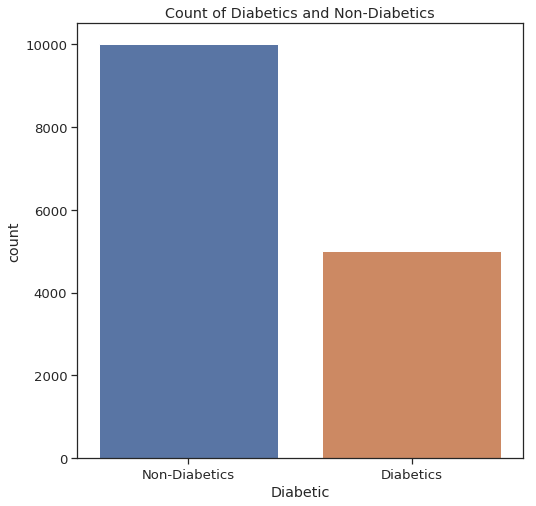

In [107]:
plt.figure(figsize=(8, 8))

x = diabetes_doctor_df.Diabetic.replace(to_replace=[0, 1], value=['Non-Diabetics','Diabetics'])
sns.countplot(x)
plt.title('Count of Diabetics and Non-Diabetics')
plt.show()

We can see that out of the 15,000 observations in our dataset, the Non-Diabetic class has 10,000 entries, while Diabetic class has only 5,000 entries.<br>
This is an imbalanced Dataset and the risk involved is that our Model may learn one class features more than the other.<br>
We need to find a way to balance the Dataset for a more unbiased and reliable classification

In [108]:
work from here

SyntaxError: ignored

Before we do the split, let's select only columns that matter by deselecting PatientID and Physician columns

In [0]:
feature_matrix = diabetes_doctor_df.iloc[:,1:-2]
feature_matrix.head()

let's also define our label variable 

In [0]:
label = diabetes_doctor_df.Diabetic

label.head()

In [0]:
feature_matrix.shape

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.3, random_state=1234)

print('X_train shape is',X_train.shape)
print('X_test shape is',X_test.shape)
print('y_train shape is',y_train.shape)
print('y_test shape is',y_test.shape)

Let's build the Decision Tree Classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

Let's define a function that plots the Confusion-Matrix

In [0]:
from sklearn.metrics import classification_report


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's define a function that returns the best decison tree classifier model and outputs its parameters and a plot of the confusion matrix

In [0]:
# set max depth range limit for DTree model to iterate through from 1 to 100 to find best parameters
max_depth = 100

def decision_tree_classifier(max_depth, X_train, y_train, X_test, y_test):
    """Method takes max_depth an int, and X_train and y_train 2D/1D arrays,
    as well as test data x_test and y_test, also arrays, and returns,
    The best max_depth value, from 1 to max_depth, and its best test_accuracy score"""
    
    accuracy_dict={'max_depth':0, 'val_acc':0, 'f1_Score':0, 'log_loss':0}

    
    for i in range(1, max_depth+1):
        # Let's instantiate a model
        decision_model = DecisionTreeClassifier(criterion='entropy', max_depth = i)
        
        # Let's train the model
        decision_model.fit(X_train, y_train)
        
        # Let's make prediction on the test data
        y_hat = decision_model.predict(X_test)
        
        # Let's measure accuracy of predictions on test data
        val_accu = round(metrics.accuracy_score(y_test, y_hat),4)
        
        # Let's Measure the F1 Score
        val_f1 = round(f1_score(y_test, y_hat, average='weighted'),4)
        
        # Let's Measure Logloss
        logloss = round(log_loss(y_test, y_hat, normalize=True),4)
        
        if accuracy_dict['val_acc'] < val_accu or accuracy_dict['f1_Score'] < val_f1:
            accuracy_dict['max_depth'] = i
            accuracy_dict['val_acc'] = val_accu
            accuracy_dict['f1_Score'] = val_f1
            accuracy_dict['log_loss'] = logloss
            decision_model2 = decision_model
            
    print('Model Evaluation:')
    print(accuracy_dict)
    
    # Compute confusion matrix
    Dtrees_cnf_matrix = confusion_matrix(y_test, y_hat, labels=[1,0])
    np.set_printoptions(precision=2)


    # Plot non-normalized confusion matrix
    plt.figure(figsize=(10, 6))
    sns.set(font_scale=1.3)
    plot_confusion_matrix(Dtrees_cnf_matrix, 
                          classes=['Default=1','Non-Default=0'],
                          normalize= False,  
                          title='Confusion Matrix for Decision-Tree-Classifier')
    #print(decision_model2.get_params(deep=True))

    return decision_model2

In [0]:
decision_tree_classifier(max_depth, X_train, y_train, X_test, y_test)

Let's calculate the Precision and Recall

In [0]:
# Precision is TP / (TP + FP)
Precision = 2720 / (2720 + 238)

# Recall is TP / (TP + FN)
Recall = 2720 / (2720 + 224)

print('Precision is:',Precision,'Recall is:',Recall)

In [0]:
F1_score = 2 * (Precision * Recall) / (Precision + Recall)
F1_score

In [0]:
y_test.value_counts()

In [0]:
import tensorflow as tf

In [0]:
tf.estimator.BoostedTreesClassifier